In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import requests
import seaborn as sns
import missingno
from datetime import datetime, timedelta
import os
from os import walk
from shapely.geometry import LineString, mapping
from itertools import combinations
import re
import folium
import fiona
import pyarrow
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats

In [6]:
nyc_gdf = gpd.read_file("./shp/taxi_zones.shp")

def clean_yellow_taxi_data(df):
    """Given a yellow taxi df applies the transformations described in Data exploration and cleaning notebook"""
    # drop duplicates
    df = df.drop_duplicates()
    
    # $1.25 for trips from LaGuardia and JFK airports
    df.loc[df["PULocationID"].
                        isin(nyc_gdf[nyc_gdf["zone"].isin(["LaGuardia Airport", "JFK Airport"])].loc[:, "LocationID"].to_list()), "airport_fee"] = 1.25
    
    # negative fares, tips, tolls, and total amount to positive
#     df.loc[df["fare_amount"] < 0, "fare_amount"] = abs(df["fare_amount"])
#     df.loc[df["tip_amount"] < 0, "tip_amount"] = abs(df["tip_amount"])
#     df.loc[df["tolls_amount"] < 0, "tolls_amount"] = abs(df["tolls_amount"])
#     df.loc[df["total_amount"] < 0, "total_amount"] = abs(df["total_amount"])
    df["fare_amount"] = abs(df["fare_amount"])
    df["tip_amount"] = abs(df["tip_amount"])
    df["tolls_amount"] = abs(df["tolls_amount"])
    df["total_amount"] = abs(df["total_amount"])
    
    # drop trips with more than 9 passengers
    df = df.drop(df[df.passenger_count > 9].index)
    
    # non-zero values of MTA_tax and Improvement_surcharge to 0.5 and 0.3 respectivelly
    df.loc[df["mta_tax"] != 0, "mta_tax"] = 0.5
    df.loc[df["improvement_surcharge"] != 0, "improvement_surcharge"] = 0.3
    
    # drop super expensive-short and super cheap-long trips
    df = df.drop(df[df.trip_distance > 4000].index)
    df = df.drop(df[df.total_amount > 100000].index)
    
    # voided trips
    df.loc[df[(df.trip_distance == 0) & (df.total_amount == 0)].index, "payment_type"] = 6
    
    # drop errors
    df = df.drop(df[(df.trip_distance == 0) & (df.payment_type != 6)].index)
    df = df.drop(df[(df.total_amount == 0) & (df.payment_type != 6)].index)
    
    # Let's create some new variables
    df["travel_time"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df["travel_time_hour"] = df['travel_time'] / np.timedelta64(1, 'h')
    df["avg_speed"] = df["trip_distance"] / df["travel_time_hour"]
    df["dollar_per_mile"] = df["total_amount"] / df["trip_distance"]
    
    # drop errors
    df = df.drop(df[df.travel_time_hour <= 0].index)
    df = df.drop(df[df.travel_time_hour > 200].index)
    df = df.drop(df[df.avg_speed >= 93].index)
    
    # drop ratecode id > 6
    df = df.drop(df[df.RatecodeID > 6].index)
    
    return df
    
    

def get_cleaned_data(month_request, year):
    """Given a list of months and a year, check if the data is dowloaded or download it in order to create the df"""
    dates = [datetime(day= 1, month = month_request[month], year = year) for month in range(0,3)]
    
    taxi_trips = pd.DataFrame()
    for month in dates:
        date = str(month.year) + str("-") + str('{:02d}'.format(month.month))
        
        try:
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        except:
            url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + date + ".parquet"
            response = requests.get(url, allow_redirects=True)
            open("./data/yellow_tripdata_" + date + ".parquet", "wb").write(response.content)
            monthly_trips = pd.read_parquet("./data/yellow_tripdata_" + date + ".parquet", engine='pyarrow')
            
        taxi_trips = pd.concat([taxi_trips, monthly_trips])
            
    taxi_trips = clean_yellow_taxi_data(taxi_trips)
        
    return taxi_trips
    

def scatterplot(df, var1, var2):
    """Given two variables of a df makes a scatter plot"""
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1 , y=var2)

In [7]:
month_request = [3, 6, 11]
year = 2017
taxi_trips_2017 = get_cleaned_data(month_request, year)

C:\Users\berta\AppData\Local\Temp\ipykernel_45496\1309518033.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fare_amount"] = abs(df["fare_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_45496\1309518033.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tip_amount"] = abs(df["tip_amount"])
C:\Users\berta\AppData\Local\Temp\ipykernel_45496\1309518033.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

First of all, let's analyze the most valuable variable of our dataset: total amount. In the cleaning function super expensive trips were drop off but for now we don't know if it was enough

In [23]:
taxi_trips_2017.total_amount.describe()

count    1.021991e+07
mean     1.614927e+01
std      1.445330e+01
min      0.000000e+00
25%      8.500000e+00
50%      1.180000e+01
75%      1.780000e+01
max      8.015800e+03
Name: total_amount, dtype: float64

Text(0.5, 1.0, 'Total amount distribution between 0 and 100')

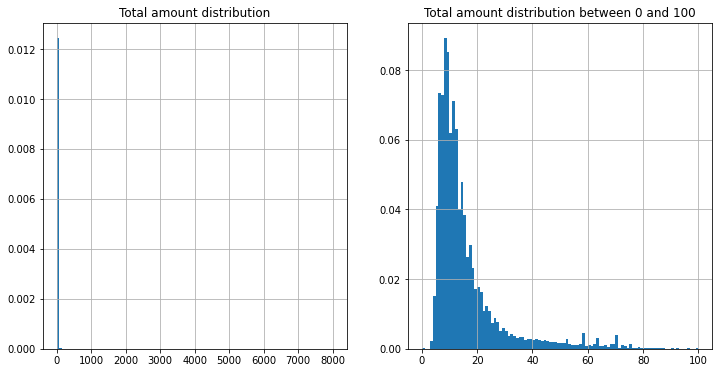

In [17]:
plt.subplot(1,2,1)
taxi_trips_2017.total_amount.hist(bins=100, figsize=(12,6), density=True)
plt.title('Total amount distribution')
plt.subplot(1,2,2)
taxi_trips_2017.total_amount.hist(bins=100, figsize=(12,6), range=[0, 100], density=True)
plt.title('Total amount distribution between 0 and 100')

Analysing the distribution of total amount there are some points to take into account:

    1. Most observations are close to 0, however there are super expensive trips... Max is higher than 8000...
    2. Total amount is deviated from the normal distibution
    3. Total amount have appreciable possitive skewness and show peakedness

In [25]:
#skewness and kurtosis
print("Skewness: %f" % taxi_trips_2017['total_amount'].skew())
print("Kurtosis: %f" % taxi_trips_2017['total_amount'].kurt())

Skewness: 55.590303
Kurtosis: 28048.595438


Let's explore the relationship between total amount and other numerical variables

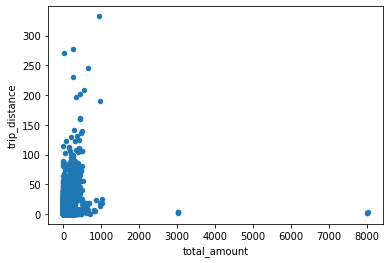

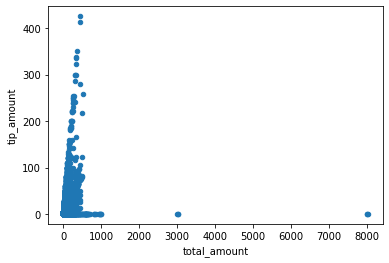

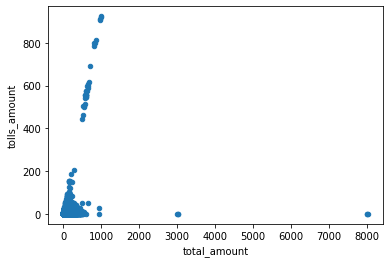

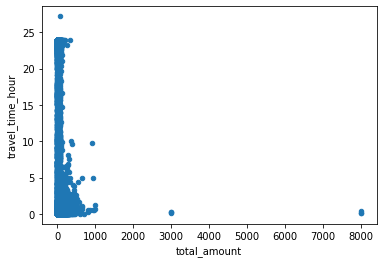

In [52]:
scatterplot(taxi_trips_2017, "total_amount", "trip_distance")
scatterplot(taxi_trips_2017, "total_amount", "tip_amount")
scatterplot(taxi_trips_2017, "total_amount", "tolls_amount")
scatterplot(taxi_trips_2017, "total_amount", "travel_time_hour")

And not numerical variables

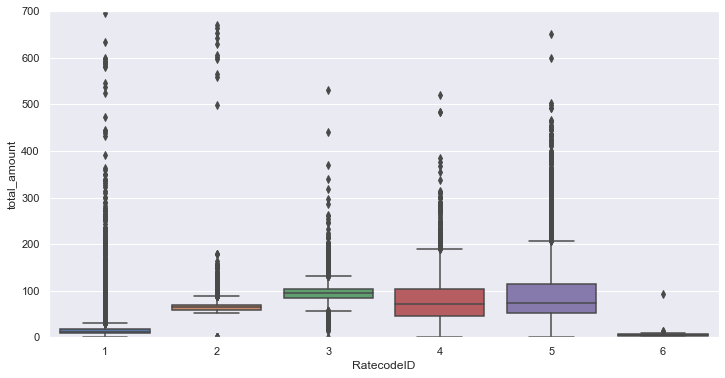

In [65]:
#box plot overallqual/saleprice
var = 'RatecodeID'
data = pd.concat([taxi_trips_2017['total_amount'], taxi_trips_2017[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="total_amount", data=data)
fig.axis(ymin=0, ymax=700);

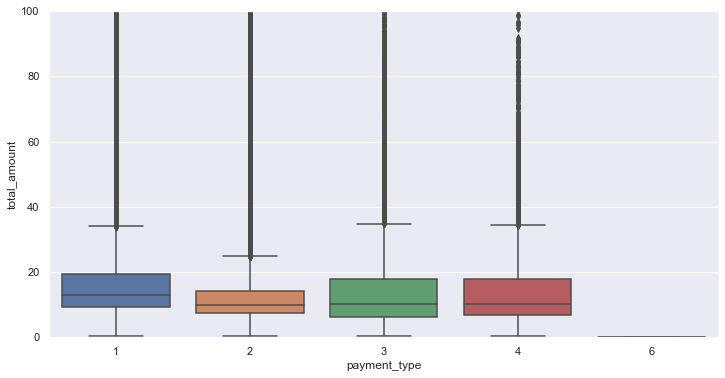

In [66]:
#box plot overallqual/saleprice
var = 'payment_type'
data = pd.concat([taxi_trips_2017['total_amount'], taxi_trips_2017[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x=var, y="total_amount", data=data)
fig.axis(ymin=0, ymax=100);

In [ ]:
#standardizing data
totalamount_scaled = StandardScaler().fit_transform(taxi_trips_2017['total_amount'][:,np.newaxis]);
low_range = totalamount_scaled[totalamount_scaled[:,0].argsort()][:20]
high_range= totalamount_scaled[totalamount_scaled[:,0].argsort()][-20:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

- The two super expensive values (some graphs above) seem strange and are not following the crowd... Maybe there are errors or maybe not but are not representative so we will define them as outliers
- Low values are near to 0, however there are many high values wich are out of range, so it is crucial to be careful

In [8]:
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.total_amount > 3000].index)

<AxesSubplot:>

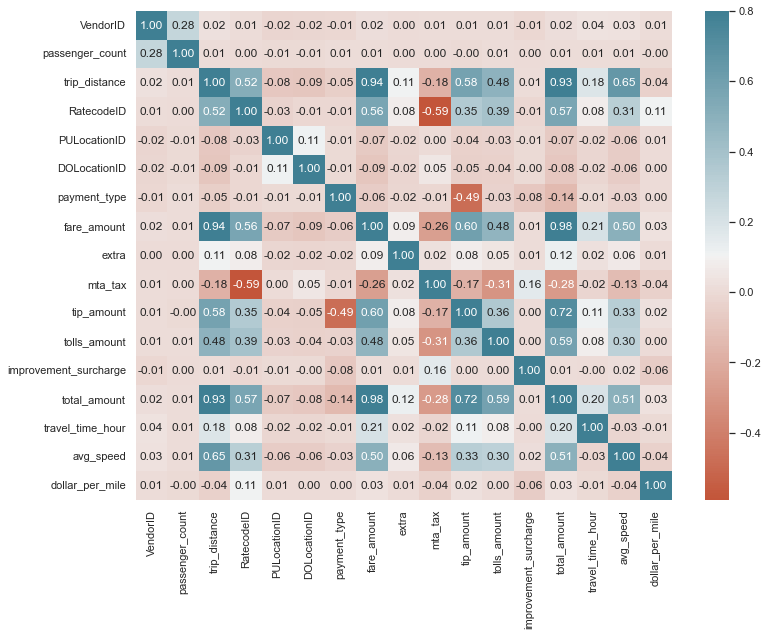

In [67]:
corrmat = taxi_trips_2017.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, cmap=sns.diverging_palette(20, 220, n=200), fmt='.2f', square=False, annot=True)

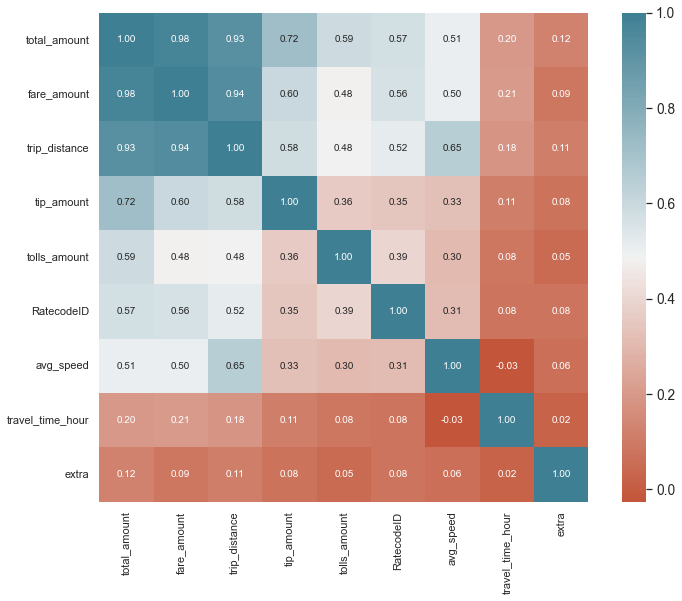

In [68]:
#total_amount correlation matrix
k = 9 #number of variables for heatmap
f, ax = plt.subplots(figsize=(12, 9))
cols = corrmat.nlargest(k, 'total_amount')['total_amount'].index
cm = np.corrcoef(taxi_trips_2017[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

As we can expect, the most correlated variables to total_amount are fare and tip amount and trip distance... 

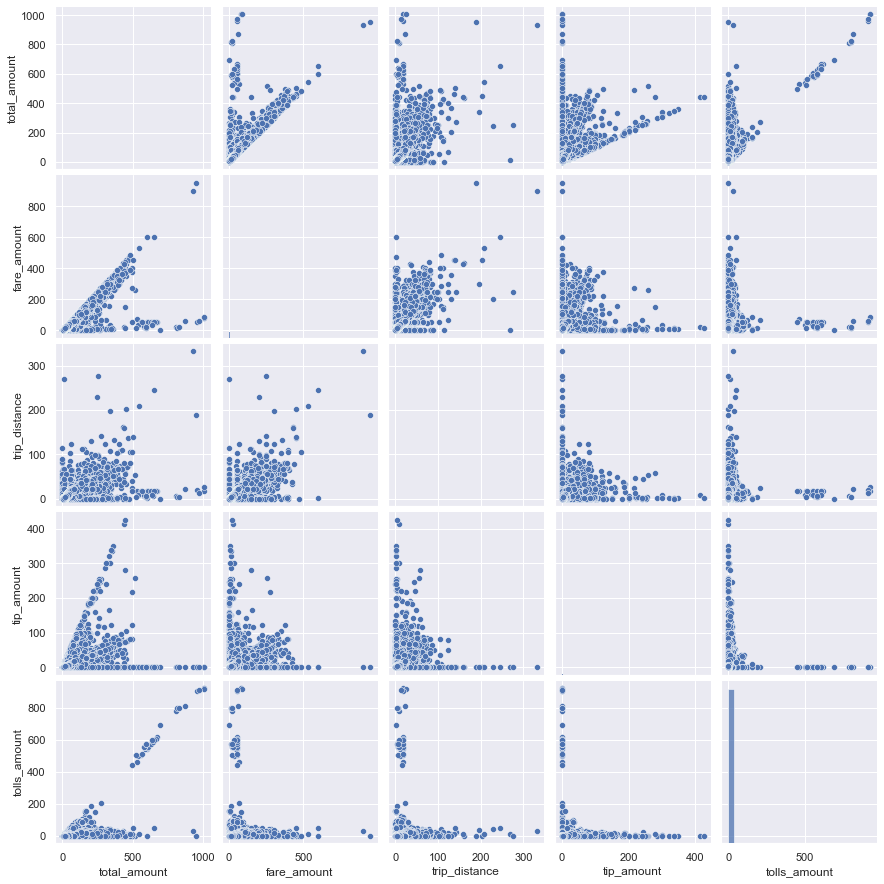

In [69]:
#scatterplot
sns.set()
cols = ['total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount']
sns.pairplot(taxi_trips_2017[cols], height = 2.5)
plt.show();

<AxesSubplot:>

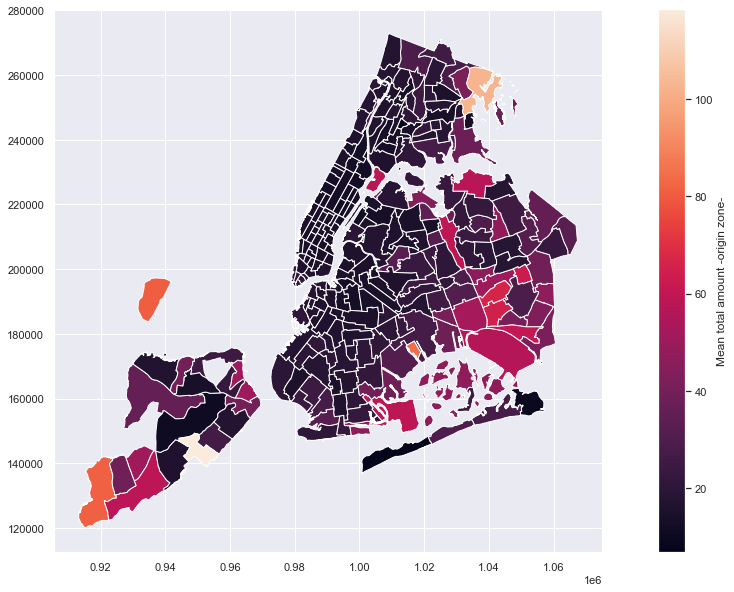

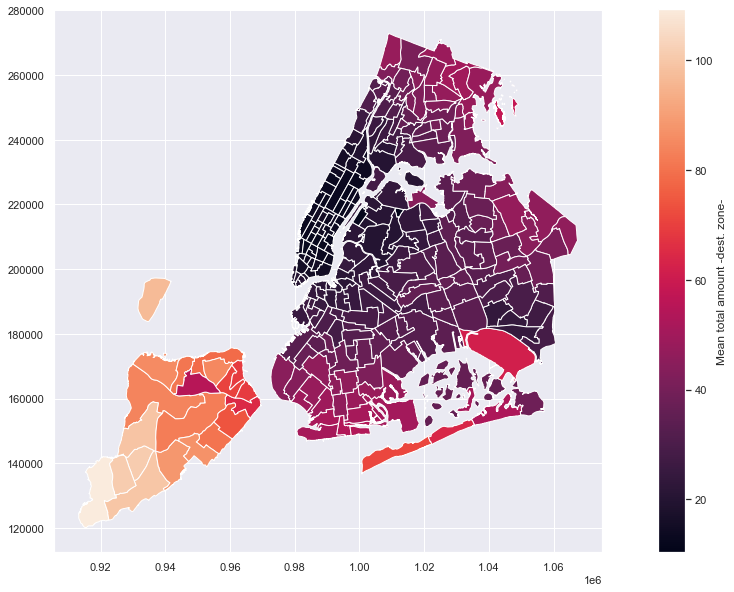

In [112]:
total_amount_mean_origin = dict(zip(taxi_trips_2017.groupby("PULocationID").agg({"total_amount": "mean"}).index,
                                taxi_trips_2017.groupby("PULocationID").agg({"total_amount": "mean"})["total_amount"]))
total_amount_mean_destination = dict(zip(taxi_trips_2017.groupby("DOLocationID").agg({"total_amount": "mean"}).index,
                                         taxi_trips_2017.groupby("DOLocationID").agg({"total_amount": "mean"})["total_amount"]))

nyc_gdf["total_amount_mean_origin"] = nyc_gdf["LocationID"].map(total_amount_mean_origin)
nyc_gdf["total_amount_mean_destination"] = nyc_gdf["LocationID"].map(total_amount_mean_destination)

nyc_gdf.plot(column = 'total_amount_mean_origin',
             legend = True,
             figsize = [20,10],
             legend_kwds = {'label': "Mean total amount -origin zone-"})

nyc_gdf.plot(column = 'total_amount_mean_destination',
             legend = True,
             figsize = [20,10],
             legend_kwds = {'label': "Mean total amount -dest. zone-"})

In [14]:
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.tpep_pickup_datetime.dt.month.isin([12, 1])].index)
taxi_trips_2017 = taxi_trips_2017.drop(taxi_trips_2017[taxi_trips_2017.tpep_pickup_datetime.dt.year != 2017].index)

<AxesSubplot:xlabel='tpep_pickup_datetime'>

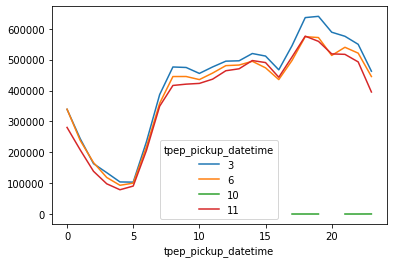

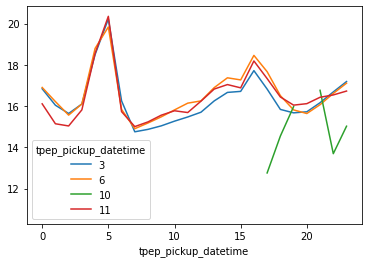

In [19]:
taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['tpep_pickup_datetime'].dt.month])['total_amount'].count().unstack().plot()

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['tpep_pickup_datetime'].dt.month])['total_amount'].mean().unstack().plot()

Most of trips are recorded in the afternoon, however, trips are more expensive at night. Let's introduce a new variable according to time
Month distributions look similar which indicate that there are not seasonal scenarios to evaluate
Let's see what happen in different weekdays... 

<AxesSubplot:xlabel='tpep_pickup_datetime'>

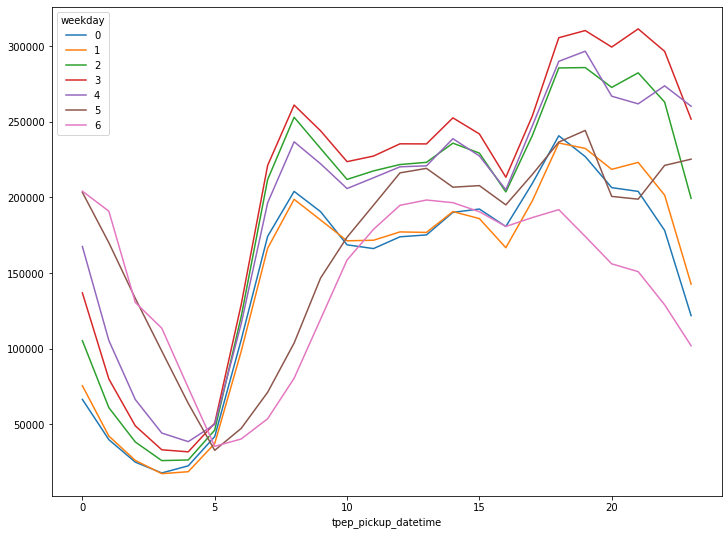

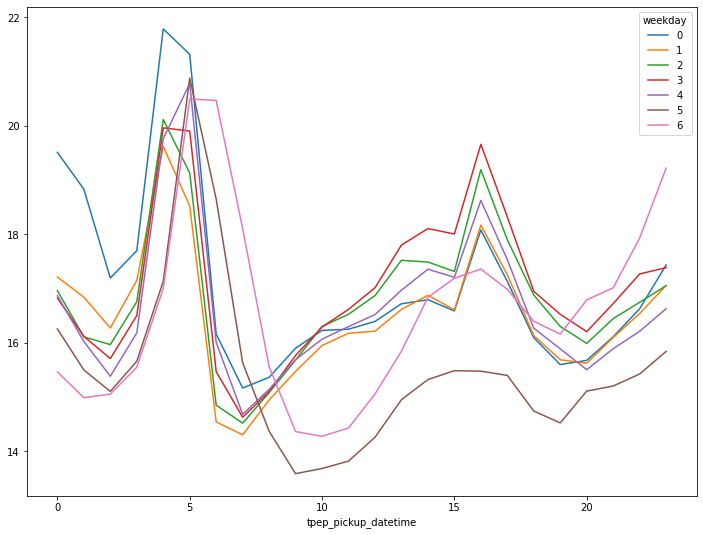

In [28]:
taxi_trips_2017['weekday'] = taxi_trips_2017['tpep_pickup_datetime'].dt.dayofweek

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['weekday']])['total_amount'].count().unstack().plot(figsize=(12, 9))

taxi_trips_2017.groupby([taxi_trips_2017['tpep_pickup_datetime'].dt.hour, 
                         taxi_trips_2017['weekday']])['total_amount'].mean().unstack().plot(figsize=(12, 9))

MemoryError: Unable to allocate 1.65 GiB for an array with shape (220920000,) and data type int64

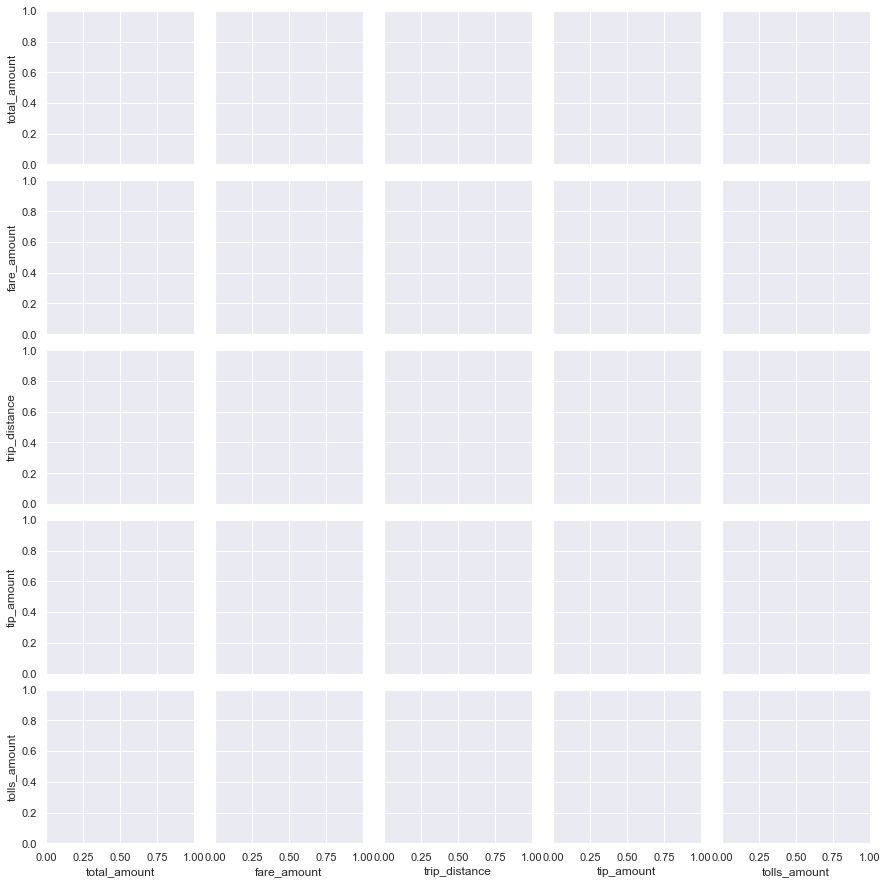

In [29]:
#scatterplot
sns.set()
cols = ['total_amount', 'fare_amount', 'trip_distance', 'tip_amount', 'tolls_amount']
sns.pairplot(taxi_trips_2017[cols], height = 2.5)
plt.show();

In [106]:
nyc_gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,total_amount_mean_origin
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",80.801374
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",47.325714
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",15.268000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",14.597754
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",50.826667
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",25.834754
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",15.981870
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",20.185344
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",13.606450


In [85]:
nyc_gdf[nyc_gdf["zone"].str.contains("Newark")]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."


In [83]:
nyc_gdf[nyc_gdf["zone"].str.contains("Westchester")]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
249,250,0.079626,0.000241,Westchester Village/Unionport,250,Bronx,"POLYGON ((1026991.885 245048.502, 1027255.054 ..."


In [84]:
nyc_gdf[nyc_gdf["zone"].str.contains("JFK")]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283..."


In [70]:
#standardizing data
totalamount_scaled = StandardScaler().fit_transform(taxi_trips_2017['total_amount'][:,np.newaxis]);
low_range = totalamount_scaled[totalamount_scaled[:,0].argsort()][:20]
high_range= totalamount_scaled[totalamount_scaled[:,0].argsort()][-20:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

C:\Users\berta\AppData\Local\Temp\ipykernel_54464\4243904875.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  totalamount_scaled = StandardScaler().fit_transform(taxi_trips_2017['total_amount'][:,np.newaxis]);


outer range (low) of the distribution:
[[-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]
 [-1.17911554]]

outer range (high) of the distribution:
[[42.75973033]
 [43.13436473]
 [44.74098399]
 [45.11196698]
 [45.74512103]
 [46.34760325]
 [46.4995018 ]
 [47.28309383]
 [47.70665709]
 [49.67549596]
 [57.8721753 ]
 [58.58639059]
 [59.12679889]
 [62.60220846]
 [66.72245657]
 [68.40210398]
 [68.87605666]
 [69.68009657]
 [72.27259583]
 [72.30910991]]


In [ ]:
Ok.. Low values are near to 0, however there are many high values wich are out of range, so it is crucial to be careful

AttributeError: 'PolyCollection' object has no property 'fit'

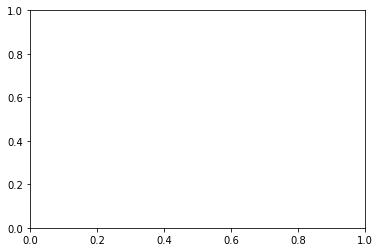

In [43]:
#histogram and normal probability plot
sns.histplot(taxi_trips_2017['total_amount'], fit=norm)
fig = plt.figure()
res = stats.probplot(taxi_trips_2017['total_amount'], plot=plt)